**Deep Learning Exam - June 2022**\
Epis Pietro 0001030354

After an exhaustive research about the most spread and consolidated tecniques to solve the task of image denoising and deblurring, I decided to base my solution on the approach proposed in the paper [Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising](https://arxiv.org/pdf/1608.03981v1.pdf), edited by Kai Zhang, Wangmeng Zuo, Yunjin Chen, Deyu Meng, and Lei Zhang. The ideal strategy to fulfill the requirements, according to the paper, is based on the so called *Denoising Convolutional Neural Networks* (DnCNNs), also exploiting residual learning and batch normalization to enhance the denoising performance. I also made some attempts with generative models, but the result I managed to achieve wasn't satisfactory, and anyway worse than the one reached with this final solution, despite the drawback in terms of complexity and training time of the generative models I tested.
Furthermore, the adopted model allows to deal with a generic unknown level of Gaussian noise.

In [ ]:
import tensorflow as tf 
from tensorflow.keras.layers import *
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import random
from cv2 import GaussianBlur
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [ ]:
def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

The dataset that has been provided is made up by 60000 images, splitted into a training set of 50000 images and a test set of 10000. Each image is of shape 32px by 32px.

In [ ]:
data = getDataset()

170508288/170498071 [==============================] - 3s 0us/step


**Network Architecture**\
First of all, the input of the network, so the noisy observation, is represented as $y = x + v$, where $v$ is the noise. Unlike what happens with discriminative denoising models, whose goal is to predict, or generate, the clean image, and therefore learn a mapping $F(y) = x$, DnCNN follow a different approach. My network stands on the residual learning idea, in order to learn instead a residual mapping, $R(y) = v$. Then, the clean image will be recoverd through the inverse formula, that is $x = y - R(y)$.

The network architecture is based on three different types of composite layers:

1.   Convolutional layer and ReLU activation layer: this has been implemented through 64 filters of size 3 x 3 x 3 (indeed we're dealing with RGB images, thus having three color channels), that therefore produces 64 feature maps as output.  
2.   Convolutional layer, Batch Normalization layer and ReLU activation layer: the Convolutional layer consists in 64 filters of size 3 x 3 x 64. The Batch Normalization layer is put between the Convolutional and the Activation ones, and its goal is speed up training and enhance the denoising capability. The Batch Normalization technique, indeed, allows to have a more stable training phase, besides requiring way less epochs to fulfill the training task, by normalizing the input of each layer in relation to mean and variance of the current batch.
3.   Convolutional Layer: this is made up by 3 filters of size 3 x 3 x 64, in order to reconstruct the output (of size 32 x 32 x 3).

The actual architecture is made up by one layer of the first type, $k$ layers of the second type, and finally one layer of the third type. After some trials, $k$ has been set to 11, that allowed to get adequate results, maintaining a relatively low number of parameters (412547) and a reasonable training time (more or less half an hour).

Finally, a Subtract layer has been added at the end of the network, in order to implement the idea at the basis of DnCNN, thus subtracting the estimated noise from the input image and therefore implementing residual learning, as already explained previously. The Subtract layer provided by Keras accepts as argument an array of two items, and it's behavior consists in subtracting the second from the first one. Hence, in our case it's meant to subtract the residual estimated by the network (represented by variable ```x```) from the input image (represented by variable ```input```, that is the input layer), finally obtaining the clean image.

The network architecture can be better appreciated and inspected through the following scheme:

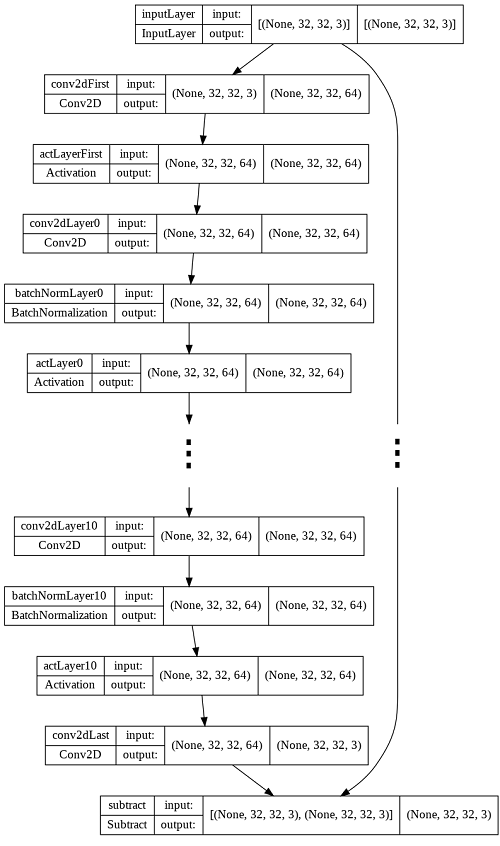

In [ ]:
input = Input(shape = (32,32,3), name = "inputLayer")
x = Conv2D(64, kernel_size = (3,3), padding = "same", name = "conv2dFirst")(input)
x = Activation("relu", name = "actLayerFirst")(x)
for i in range(11):
    x = Conv2D(64, kernel_size = (3,3), padding = "same", name = "conv2dLayer" + str(i))(x)
    x = BatchNormalization(axis = -1, name = "batchNormLayer" + str(i))(x)
    x = Activation("relu", name = "actLayer" + str(i))(x)
x = Conv2D(3, kernel_size = (3,3), padding = "same", name = "conv2dLast")(x)
x = Subtract(name="subtract")([input, x])

model = tf.keras.Model(input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputLayer (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2dFirst (Conv2D)           (None, 32, 32, 64)   1792        ['inputLayer[0][0]']             
                                                                                                  
 actLayerFirst (Activation)     (None, 32, 32, 64)   0           ['conv2dFirst[0][0]']            
                                                                                                  
 conv2dLayer0 (Conv2D)          (None, 32, 32, 64)   36928       ['actLayerFirst[0][0]']          
                                                                                              

**Loss and Metrics**\
The measure that has been used as loss function for the training of the network is MSE (Mean Squared Error). As regards instead the metrics that have been chosen for the evaluation of the results of the model, I decided to use two different measures. Beyond the MSE, required by the exam instructions, I found it convenient to assess also the **PSNR** (Peak Signal-to-Noise Ratio).

I decided to take care of PSNR too since this is commonly exploited as a metric to evaluate the quality of an image obtained from noise removal, and therefore I thought it could provide some insights about the results.\
As the acronym suggests, PSNR refers to the ratio between the maximum possible value of a signal and the strength of the noise affecting it. This means that a higher PSNR value implies better results.\
Formally, given the clean image $x$ (groundtruth) and the noisy blurred one $y$, PSNR is defined as:

$PSNR = 20 \text{ } log_{10} (\frac{MAX_y}{\sqrt{MSE}})$

referring to $MAX_y$ as the highest value into image $y$.\
MSE, instead, is defined as

$MSE = \frac{1}{mn} \sum_{0}^{m-1} \sum_{0}^{n-1} \lVert y(i, j) - x(i, j) \rVert^2$ 

(where $m$ and $n$ are the images dimensions)

As regards the learning rate, I chose it after some tuning, and I found out 0.0001 being a suitable value. Indeed, lower values made the training phase eccessively slow, and the results were worse, maybe because of getting stuck into suboptimal solutions. On the other hand, higher values for the rate made the learning process too oscillatory, and the performance (loss) of the model were unstable over the epochs.

In [ ]:
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1)

model.compile(
  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
  loss = "mse",
  metrics = [tf.keras.metrics.MeanSquaredError(), PSNR]
)

**Training**\
I empirically determined, after several trials, a suitable number of epochs in order to get the best possible metrics (lowest MSE) without running into overfitting (as explained later in more detail). I found out that a convenient number is 40.

I decided to further split the dataset and create a validation set, with size equal to 1/10 of the training set, in order to have an additional way to better assess the presence of overfitting.

In [ ]:
# data[0] is the training set, therefore data[0][0] is input and data[0][1] the
# expected output (groundtruth)

history = model.fit(
    data[0][0], data[0][1],
    batch_size = 16,
    epochs = 40,
    validation_split = 0.1
)

Epoch 1/40
2813/2813 [==============================] - 58s 17ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - PSNR: 22.4961 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_PSNR: 23.9425
Epoch 2/40
2813/2813 [==============================] - 47s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - PSNR: 24.4263 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_PSNR: 24.5988
Epoch 3/40
2813/2813 [==============================] - 47s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - PSNR: 25.0274 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_PSNR: 25.2288
Epoch 4/40
2813/2813 [==============================] - 46s 16ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - PSNR: 25.3321 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_PSNR: 25.4505
Epoch 5/40
2813/2813 [==============================] - 47s 17ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - PSNR: 25.5477 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_PSNR

**Model Evaluation**\
I made use of the ```evaluate``` method, provided by Keras, in order to get the metrics of the model, computed both on the training and test sets. Below are the results achieved for MSE and PSNR.

In [ ]:
train_eval = model.evaluate(data[0][0], data[0][1], verbose = 0)
test_eval = model.evaluate(data[1][0], data[1][1], verbose = 0)

print("TRAINING SET")
print("MSE:\t\t", train_eval[1])
print("PSNR:\t\t", train_eval[2], "\n")
print("TEST SET")
print("MSE:\t\t", test_eval[1])
print("PSNR:\t\t", test_eval[2])

TRAINING SET
MSE:		 0.002252669772133231
PSNR:		 26.993183135986328 

TEST SET
MSE:		 0.002302369801327586
PSNR:		 26.91489601135254


According to these metrics, it's already possible to take some conclusions about the absence of overfitting, indeed both the MSE and the PSNR are pretty much the same both in training and test set. Anyway, a deeper analysis on the metrics, related to the number of epochs used to train the network, is carried out in the next paragraph.

**Overfitting**\
In order to assess the presence of overfitting, that may be suspected in case the results on the training set are way much better than the ones on the validation/training set, I generated two plots reporting the metrics computed at each epoch. In particular, I decided to take into consideration the MSE metric, since it is the most relevant one and it's central in this project, but I also found it interesting to plot the PSNR metric, because of its meaningfulness in this domain.

We can clearly see for both metrics plots that the values at each epoch for both training and validation sets are pretty much the same, and basically follow the same trend. This means that the model isn't tied to the training data, it didn't adapt excessively to the fluctuations of the data, but it's able to generalize and perform well even on unseen images.

In the tuning phase of the model, I ascertained that using a noticeably higher number of epochs during training led to significant overfitting issues (for instance with 60 epochs). On the other hand, an increase in the number of epochs small enough to avoid overfitting didn't allow to get any improvement on the metrics, but just required more time for the training.

Anyway, this task didn't seem to be particularly prone to overfitting, even in previous experiments with different models having higher numbers of parameters. 

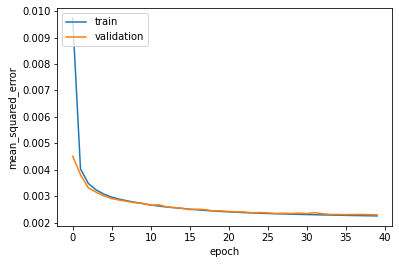

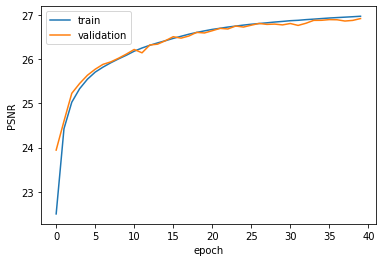

In [ ]:
def plot_history(model_history, keys):
    m, val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_history(history, ["mean_squared_error", "val_mean_squared_error"])
plot_history(history, ["PSNR", "val_PSNR"])

**Demonstration of the denoising results**\
Below it's possible to appreciate the deblurring capabilities of the network, by visually inspecting the results. The first image is the original, unblurred, one (the groundtruth). The second image is the one obtained by the addition of Gaussian noise (the input of the network). The last image is the result produced by the network. It was necessary to clip the pixels values when plotting the images, indeed in some instances it happend that the noisy and the restored images had some value slightly out of the [0, 1] range. 

By default I plot this sequence of images just for the first ten instances of the test set. Anyway, it's possible to inspect the results on different ranges of images by varying the parameters ```FROM_IMAGE``` and ```TO_IMAGE```.



Image 1


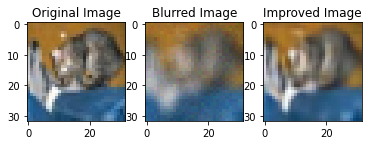

Image 2


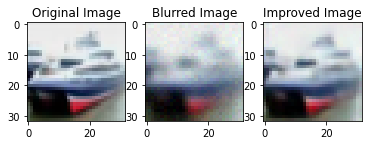

Image 3


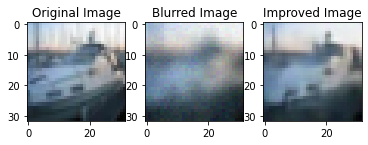

Image 4


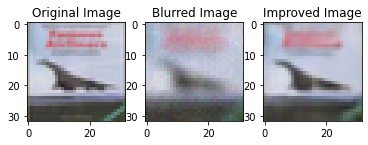

Image 5


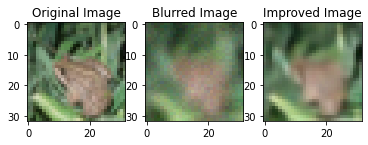

Image 6


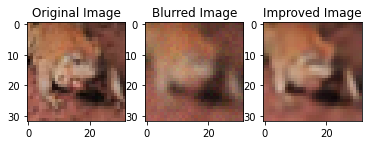

Image 7


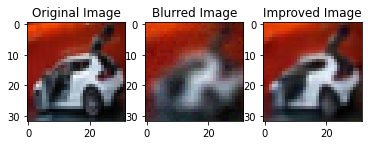

Image 8


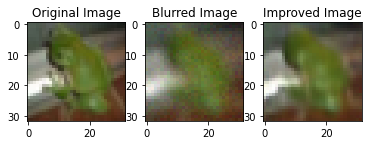

Image 9


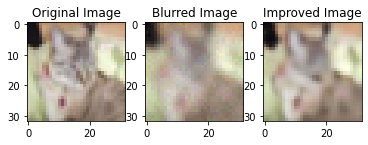

Image 10


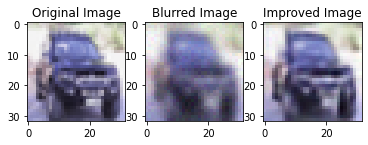

Image 11


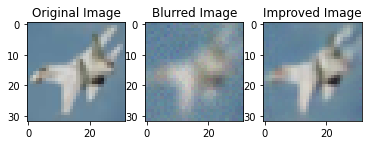

In [ ]:
FROM_IMAGE = 0
TO_IMAGE = 10

for i in range(FROM_IMAGE, TO_IMAGE + 1):
  print("Image", (i + 1))
  p = np.clip(model.predict(data[1][0][i:(i + 1)]), 0, 1)
  plt.subplot(1, 3, 1)
  plt.title("Original Image")
  plt.imshow(data[1][1][i], vmin=0, vmax=1)
  plt.subplot(1, 3, 2)
  plt.title("Blurred Image")
  plt.imshow(np.clip(data[1][0][i], 0, 1), vmin=0, vmax=1)
  plt.subplot(1, 3, 3)
  plt.title("Improved Image")  
  plt.imshow(p[0], vmin=0, vmax=1)
  plt.show()

**Conclusions**\
The final model used to solve the assigned task is the result of several experiments and trials, that allowed to integrate lots of the models, architectures and tecniques that have been presented and discussed during the course, besides an additional research to discover the most commonly adopted and stable approaches to solve this kind of problems.\
Furthermore, in order to devise a model ensuring adequate performance, lots of parameter tuning and changes to the starting architecture have been done.

The resulting metrics have been improved until a MSE of 0.0023 was reached on the test set, that seemed to be some kind of barrier that couldn't be overcome. As regards the visual results, and so the comparison between the input and output images, it's possible to notice a significant improvement, with the resulting image being closer to the clean one than to the noisy one. The improvement is particularly visible on the edges, that become sharper and more definite, besides a noticeable gain as regards the recognizability of the image. Anyway, it's ardouous to assess the results visually, since the dataset is composed of images that are so small that sometimes it's hard even to recognize the subject.

In [ ]:
model.save_weights("11l-40e.h5")